### The problem and the data
Artists like Claude Monet can  be imitated with algorithms thanks to generative adversarial networks (GANs). In this mini project, we will bring that style to the photos taken from camera.

The dataset contains four directories: *monet_tfrec*, *photo_tfrec*, *monet_jpg*, and *photo_jpg*. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

We will use TFRecords to deserialize the Monet images as well as the camera photos from tfrec files where Monet images will be used to train the model. As the outcome of the project, we will add Monet-style to these images so that the camera taken photos will have a flavor of Monet. A zip file containing 10,000 immages will eventually produced for final submission.



In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.3 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

2.11.0


### Exploratory data analysis

Images are  sized to 256x256. Since these images are RGB images, the channel will be 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [ ]:
# GCS_PATH = KaggleDatasets().get_gcs_path()
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


In [ ]:
GCS_PATH = '/content/gdrive/MyDrive/data-lab/input/gan-getting-started'

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, we set the channel to 3. Additionally, we will scale the images to a [-1, 1]. Since we need to compare the input image $𝐼$
 to the output image $\hat{𝐼}$
, it should be readily possible to enforce the pixel values of $\hat{I}$
 into a simple, known, hard range. Using sigmoid produces values in [0,1]
, while using tanh does so in [−1,1]
. However, it is often thought that that tanh is better than sigmoid.

In [ ]:
IMAGE_SIZE = [256, 256]

def decodeNormalizeImage(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def readTfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decodeNormalizeImage(example['image'])
    return image

Define the function to extract the image from the files.

In [ ]:
def loadData(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(readTfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [ ]:
monetDs = loadData(MONET_FILENAMES).batch(1)
photoDs = loadData(PHOTO_FILENAMES).batch(1)

### Visualizating the Monet image and photo

Text(0.5, 1.0, 'Monet')

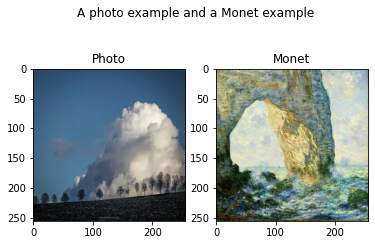

In [ ]:
exampleMonet = next(iter(monetDs))
examplePhoto = next(iter(photoDs))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('A photo example and a Monet example')
ax1.imshow(examplePhoto[0] * 0.5 + 0.5)
ax1.set_title('Photo')
ax2.imshow(exampleMonet[0] * 0.5 + 0.5)
ax2.set_title('Monet')

### Model Architecture

The GAN architecture is an approach to training a model for image synthesis that is comprised of two models: a generator model and a discriminator model. The generator takes a point from a latent space as input and generates new plausible images from the domain, and the discriminator takes an image as input and predicts whether it is real (from a dataset) or fake (generated). Both models are trained, such that the generator is updated to better fool the discriminator and the discriminator is updated to better detect generated images.

To solve the problem in this project, we will build CycleGAN.The CycleGAN is an extension of the GAN architecture that involves the simultaneous training of **two generator models and two discriminator models**.

One generator takes images from the first domain as input and outputs images for the second domain, and the other generator takes images from the second domain as input and generates images for the first domain. Discriminator models are then used to determine how plausible the generated images are and update the generator models accordingly.

This extension alone might be enough to generate plausible images in each domain, but not sufficient to generate translations of the input images.

We'll be using a UNET architecture for our CycleGAN. To build our generator, let's first define our `downsample` and `upsample` methods. As the name suggests, `downsample` will decrease the number of dimensions of the image, whereas `upsample` will increase the number of dimensions of the image. With downsampling, the stride is the length of the step the filter takes. Since we will set the stride as 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization, as it computes the mean/variance across each channel of each training image. It is used in style transfer applications and has also been suggested as a replacement to batch normalization in GANs.

In [ ]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### Build the generator

The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

### Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.

Leaky ReLU is used below, as it is very popular because they help the gradients flow easier through the architecture.

A regular ReLU function works by truncating negative values to 0. This has the effect of blocking the gradients to flow through the network. Instead of the function being zero, leaky RELUs allow a small negative value to pass through. That is, the function computes the greatest value between the features and a small factor.

Leaky RELUs represent an attempt to solve the dying ReLU problem. This situation occurs when the neurons get stuck in a state in which RELU units always output 0s for all inputs. For these cases, the gradients are completely shut to flow back through the network. This is especially important for GANs since the only way the generator has to learn is by receiving the gradients from the discriminator.

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
# with strategy.scope():
monetGenerator = Generator() # transforms photos to Monet styled paintings
photoGenerator = Generator() # transforms Monet paintings to be like photos

monetDiscriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photoDiscriminator = Discriminator() # differentiates real photos and generated photos

Since our generators are not trained yet, the generated Monet-esque photo does not show what is expected at this point.

### Build the CycleGAN model

CycleGan will extend `tf.keras.Model` so that `fit()` can be called later to train the model. During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another.

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monetGenerator,
        photoGenerator,
        monetDiscriminator,
        photoDiscriminator,
        lambdaCycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monetGenerator
        self.p_gen = photoGenerator
        self.m_disc = monetDiscriminator
        self.p_disc = photoDiscriminator
        self.lambdaCycle = lambdaCycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambdaCycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambdaCycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambdaCycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambdaCycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

### Loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

In [ ]:
# with strategy.scope():
def discriminatorLoss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
# with strategy.scope():
def generatorLoss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
# with strategy.scope():
def calcCycleLoss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
# with strategy.scope():
def identityLoss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### Train the CycleGAN

Let's compile our model. Since we used `tf.keras.Model` to build our CycleGAN, we can just ude the `fit` function to train our model. We use Adam and start with the default values. **Adam** - adaptive moment estimation is simply a combination of Momentum and RMSProp, which includes the hyperparameters: $\alpha$, $\beta{1}$ (from Momentum), $\beta{2}$ (from RMSProp).



In [ ]:
# with strategy.scope():
monetGeneratorOptimizer = tf.keras.optimizers.Adam()
photoGeneratorOptimizer = tf.keras.optimizers.Adam()

monetDiscriminatorOptimizer = tf.keras.optimizers.Adam()
photoDiscriminatorOptimizer = tf.keras.optimizers.Adam()

In [ ]:
# with strategy.scope():
cycleganModel = CycleGan(
    monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator
)

cycleganModel.compile(
    m_gen_optimizer = monetGeneratorOptimizer,
    p_gen_optimizer = photoGeneratorOptimizer,
    m_disc_optimizer = monetDiscriminatorOptimizer,
    p_disc_optimizer = photoDiscriminatorOptimizer,
    gen_loss_fn = generatorLoss,
    disc_loss_fn = discriminatorLoss,
    cycle_loss_fn = calcCycleLoss,
    identity_loss_fn = identityLoss
)

In [ ]:
history1 = cycleganModel.fit(
    tf.data.Dataset.zip((monetDs, photoDs)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 96s 104ms/step - monet_gen_loss: 2.8329 - photo_gen_loss: 2.9423 - monet_disc_loss: 0.6148 - photo_disc_loss: 0.5811
Epoch 2/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 2.7703 - photo_gen_loss: 2.8793 - monet_disc_loss: 0.6273 - photo_disc_loss: 0.5800
Epoch 3/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 2.8110 - photo_gen_loss: 2.8980 - monet_disc_loss: 0.6174 - photo_disc_loss: 0.5871
Epoch 4/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 2.7548 - photo_gen_loss: 2.8808 - monet_disc_loss: 0.6309 - photo_disc_loss: 0.5881
Epoch 5/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 2.7517 - photo_gen_loss: 2.8347 - monet_disc_loss: 0.6053 - photo_disc_loss: 0.5885
Epoch 6/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 2.8351 - photo_gen_loss: 3.0199 - monet_disc_loss: 0.6163 

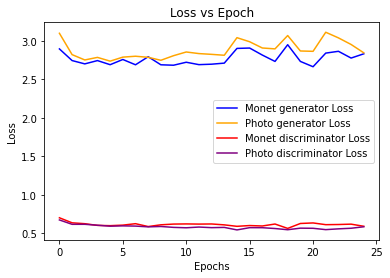

In [ ]:
history_dict1 = history1.history
history_dict1.keys()
epochs1=range(25)
monet_gen_loss1  = history_dict1['monet_gen_loss']
photo_gen_loss1  = history_dict1['photo_gen_loss']
monet_disc_loss1 = history_dict1['monet_disc_loss']
photo_disc_loss1 = history_dict1['photo_disc_loss']


plt.plot(epochs1, monet_gen_loss1, 'blue',   label='Monet generator Loss')
plt.plot(epochs1, photo_gen_loss1, 'orange', label='Photo generator Loss')
plt.plot(epochs1, monet_disc_loss1,'red',    label='Monet discriminator Loss')
plt.plot(epochs1, photo_disc_loss1,'purple', label='Photo discriminator Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Fine tune hyperparameters and retrain the model
Adam is an extension of SGD, and it combines the advantages of AdaGrad and RMSProp. Adam is also an adaptive gradient descent algorithm, such that it maintains a learning rate per-parameter. And it keeps track of the moving average of the first and second moment of the gradient. Thus, using the first and second moment, Adam can give an unscaled direct estimation of the parameter’s updates. Finally, although newer optimization algorithms have emerged, Adam (and SGD) is still a stable optimizer to use.
In the next section, let's try to fine tune the hyperparameters by having smaller learning rate and have $\beta{1}=0.5$. We will retrain the model and plot the loss vs epochs chart again.

In [ ]:
# with strategy.scope():
monetGeneratorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photoGeneratorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monetDiscriminatorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photoDiscriminatorOptimizer2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
# with strategy.scope():
cycleganModel2 = CycleGan(
    monetGenerator, photoGenerator, monetDiscriminator, photoDiscriminator
)

cycleganModel2.compile(
    m_gen_optimizer = monetGeneratorOptimizer2,
    p_gen_optimizer = photoGeneratorOptimizer2,
    m_disc_optimizer = monetDiscriminatorOptimizer2,
    p_disc_optimizer = photoDiscriminatorOptimizer2,
    gen_loss_fn = generatorLoss,
    disc_loss_fn = discriminatorLoss,
    cycle_loss_fn = calcCycleLoss,
    identity_loss_fn = identityLoss
)

In [ ]:
history2 = cycleganModel2.fit(
    tf.data.Dataset.zip((monetDs, photoDs)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 96s 105ms/step - monet_gen_loss: 2.6224 - photo_gen_loss: 2.6674 - monet_disc_loss: 0.5790 - photo_disc_loss: 0.5602
Epoch 2/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 2.6031 - photo_gen_loss: 2.6750 - monet_disc_loss: 0.5697 - photo_disc_loss: 0.5382
Epoch 3/25
300/300 [==============================] - 32s 105ms/step - monet_gen_loss: 2.6076 - photo_gen_loss: 2.6971 - monet_disc_loss: 0.5730 - photo_disc_loss: 0.5285
Epoch 4/25
300/300 [==============================] - 32s 105ms/step - monet_gen_loss: 2.6166 - photo_gen_loss: 2.7055 - monet_disc_loss: 0.5712 - photo_disc_loss: 0.5264
Epoch 5/25
300/300 [==============================] - 32s 105ms/step - monet_gen_loss: 2.6163 - photo_gen_loss: 2.7052 - monet_disc_loss: 0.5675 - photo_disc_loss: 0.5266
Epoch 6/25
300/300 [==============================] - 31s 104ms/step - monet_gen_loss: 2.6222 - photo_gen_loss: 2.7169 - monet_disc_loss: 0.5682 

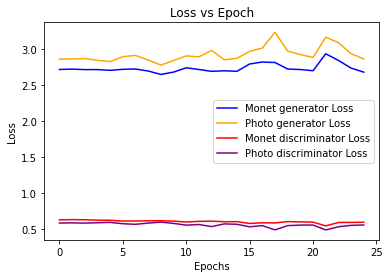

In [ ]:
history_dict2 = history2.history
history_dict2.keys()
epochs2=range(25)
monet_gen_loss2  = history_dict2['monet_gen_loss']
photo_gen_loss2  = history_dict2['photo_gen_loss']
monet_disc_loss2 = history_dict2['monet_disc_loss']
photo_disc_loss2 = history_dict2['photo_disc_loss']


plt.plot(epochs2, monet_gen_loss2, 'blue',   label='Monet generator Loss')
plt.plot(epochs2, photo_gen_loss2, 'orange', label='Photo generator Loss')
plt.plot(epochs2, monet_disc_loss2,'red',    label='Monet discriminator Loss')
plt.plot(epochs2, photo_disc_loss2,'purple', label='Photo discriminator Loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

It's quite obvious that with fine tuned adam optimizer, loss of the two generators are little bit lower. The decay worked! We decided to choose the generator trained with fine tuned adam optimizer for prediction.

### Visualize our Monet styled photos

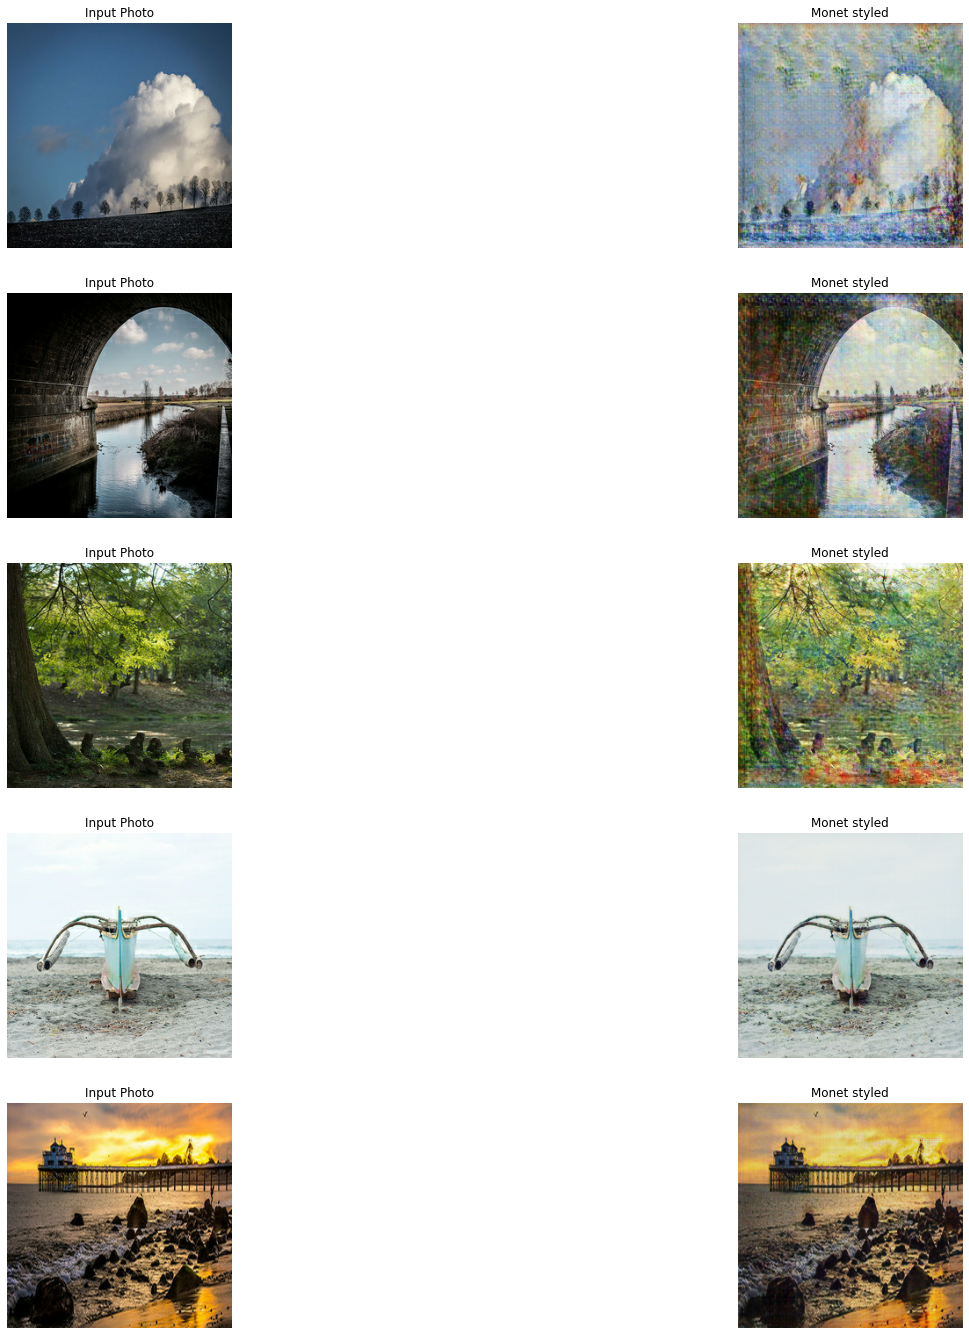

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(24, 24))
for i, img in enumerate(photoDs.take(5)):
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet styled")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Create submission file

In [ ]:
import PIL
! mkdir images

mkdir: cannot create directory ‘images’: File exists


In [ ]:
i = 1
for img in photoDs:
    prediction = monetGenerator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("images/" + str(i) + ".jpg")
    i += 1

In [ ]:
import shutil
shutil.make_archive("images", 'zip', "images")

'/content/images.zip'

### Conclusion
In this project, we discovered the CycleGAN technique for unpaired image-to-image translation where we learned CycleGAN is a technique for training unsupervised image translation models via the GAN architecture using unpaired collections of images from two different domains,i.e.,Monet styled and camera taken. If I had more time, I would like to try using DCGan to genearte Monet styled images from scratch. With fine tuned adam optimizer, we got generators with lower loss which is finally used for prediction.